In [34]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from src.pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

In [26]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

vae/diffusion_pytorch_model.safetensors not found
Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 162150.93it/s]


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [27]:
# load image from filesystem
img = Image.open("in_the_wild/images/2251.jpg")
tamper = Image.open("in_the_wild/masks/2251.jpg")
# cut tampred's white border

tamper_np = np.array(tamper)
non_white_pixels = np.any(tamper_np != 255, axis=-1)
non_white_rows = np.any(non_white_pixels, axis=1)
non_white_cols = np.any(non_white_pixels, axis=0)
trimmed_tamper_np = tamper_np[non_white_rows][:, non_white_cols]
tamper = Image.fromarray(trimmed_tamper_np)





tamper = tamper.resize(img.size)

# create binary mask from image based on red blue colors the mask should have three channels
mask = np.array(tamper)[:,:,0] < 170
mask = np.stack([mask, mask, mask], axis=-1).astype(np.uint8) * 255
mask = Image.fromarray(mask)


img = img.resize((512, 512))
tamper = tamper.resize((512, 512))
mask = mask.resize((512, 512))


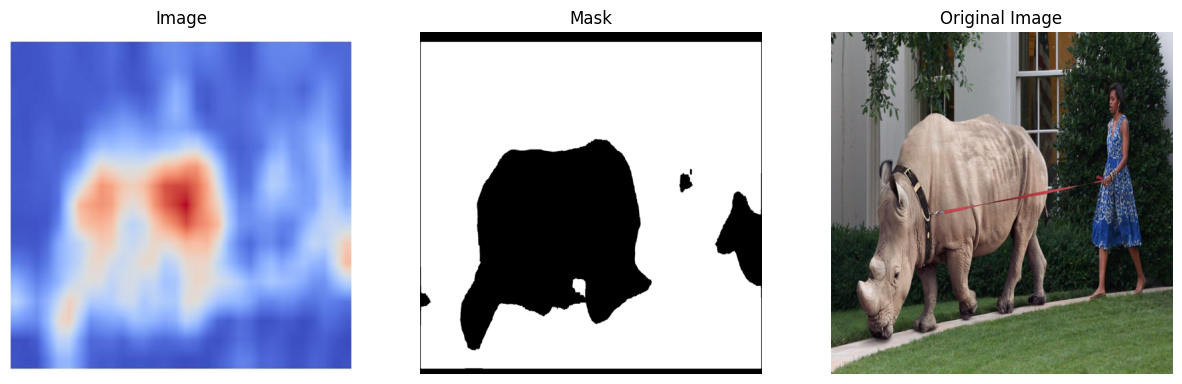

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(tamper)
plt.axis("off")
plt.title("Image")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.title("Mask")

plt.subplot(1,3,3)
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")


plt.show()

In [29]:

# print the shapes of both images
print("Image shape:", np.array(tamper).shape)
print("Mask shape:", np.array(mask).shape)
print("Original Image shape:", np.array(img).shape)
# transform the mask to have the same size as the img


Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Original Image shape: (512, 512, 3)


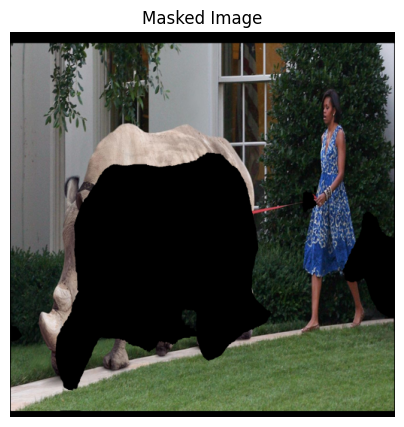

In [30]:
# do element wiese multiplication of the image and the mask
masked_img = np.array(img) * (np.array(mask) / 255)
masked_img = Image.fromarray(masked_img.astype(np.uint8))
# show the masked image
plt.figure(figsize=(5, 5))
plt.imshow(masked_img)
plt.axis("off")
plt.title("Masked Image")
plt.show()

In [35]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "A woman walking her dog",
    num_inference_steps=10,
    generator=generator,
    image=img,
    mask_image=mask
).images[0]

new_image.save('output/seg_result.png')

 58%|█████▊    | 292/500 [02:57<01:10,  2.95it/s]

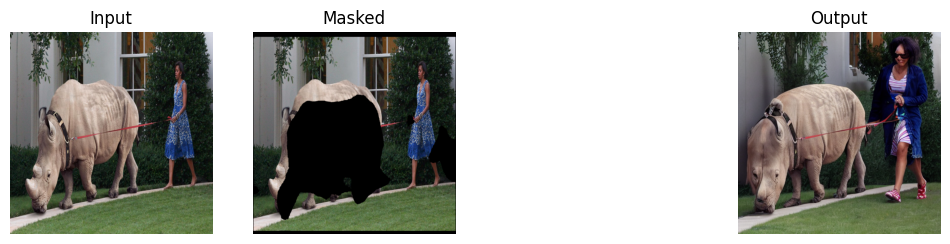

In [33]:
plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
plt.imshow(img)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow(masked_img)
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/seg_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )